# 📊 Fitbit Activities Analysis

This notebook provides comprehensive analysis of Fitbit activity data including:

- 📈 **Daily Summary**
- 🏃 **Workout Analysis**
- 🏊 **Swimming Analysis**
- 🚶 **Steps**
- ❤️ **Heart Rate Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


In [2]:
PARQUET_PATH = '../data'
TIMEZONE = 'Europe/London'

## Run All Below

Enter a target date and Run

In [21]:
TARGET_DATE = '2025-12-23'  # Date to analyze (YYYY-MM-DD)

In [22]:
# Function to get ordinal suffix for day
def get_ordinal_suffix(day):
  if 10 <= day % 100 <= 20:
      suffix = 'th'
  else:
      suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(day % 10, 'th')
  return suffix

# Parse TARGET_DATE and create formatted version
date_obj = datetime.strptime(TARGET_DATE, '%Y-%m-%d')
day = date_obj.day
suffix = get_ordinal_suffix(day)
formatted_date = date_obj.strftime(f'%A {day}{suffix} %B %Y')

---

## Load Data 📥

Load Fitbit data from Parquet files (optimized storage format).

In [23]:
from functions.load_data import load_single_date

In [24]:
dfs = load_single_date(TARGET_DATE, PARQUET_PATH, TIMEZONE)
print(f"\n📊 Data Summary for {formatted_date}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")


📊 Data Summary for Tuesday 23rd December 2025:
HeartRate_Intraday             |  39439 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     22 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
DeviceBatteryLevel             |      1 records
ActivityRecords                |      2 records
SleepSummary                   |      2 records

✅ Data loaded successfully


## dfs

---

In [25]:
df_activity_records = dfs.get('ActivityRecords')
df_hr_intra = dfs.get('HeartRate_Intraday')
df_steps_intra = dfs.get('Steps_Intraday')
total_steps = dfs.get('Activity-steps')
total_calories = dfs.get('Activity-calories')
total_distance = dfs.get('Activity-distance')
resting_hr = dfs.get('RestingHR')
df_breathing_rate = dfs.get('BreathingRate')
df_hrv = dfs.get('HRV')

In [26]:
hr_zones = {
    'Out of Range': {'range': (0, 97), 'color': '#87CEEB'},      # Grey
    'Fat Burn': {'range': (98, 122), 'color': '#98FB98'},        # Yellow/Orange
    'Cardio': {'range': (123, 154), 'color': '#FFA500'},         # Orange
    'Peak': {'range': (155, 220), 'color': '#DC143C'}            # Red
}

In [27]:
# Extract activity level data
activity_levels = {
    'Sedentary': dfs.get('Activity-minutesSedentary'),
    'Lightly Active': dfs.get('Activity-minutesLightlyActive'),
    'Fairly Active': dfs.get('Activity-minutesFairlyActive'),
    'Very Active': dfs.get('Activity-minutesVeryActive')
}

# Check if we have activity level data
has_data = any(not df.empty for df in activity_levels.values())

if has_data:
    # Collect data
    level_data = []
    total_minutes = 0
    
    # Define colors for activity levels
    level_colors = {
        'Sedentary': '#87CEEB',      # Sky blue
        'Lightly Active': '#98FB98',  # Pale green
        'Fairly Active': '#FFA500',   # Orange
        'Very Active': '#DC143C'      # Crimson
    }
    
    for level_name, df in activity_levels.items():
        if not df.empty:
            minutes = df.iloc[0]['value']
            hours = minutes / 60
            total_minutes += minutes
            
            level_data.append({
                'level': level_name,
                'minutes': minutes,
                'hours': hours,
                'color': level_colors[level_name]
            })
    
    # Calculate percentages
    for item in level_data:
        item['percentage'] = (item['minutes'] / total_minutes) * 100 if total_minutes > 0 else 0
    
else:
    print("No activity level data available")

In [28]:
if not df_hr_intra.empty:
    print(f"Analyzing {len(df_hr_intra):,} heart rate measurements\n")
    
    # Calculate time in each zone
    zone_data = []
    zone_colors = []
    
    for zone_name, zone_info in hr_zones.items():
        hr_in_zone = df_hr_intra[
            (df_hr_intra['value'] >= zone_info['range'][0]) &
            (df_hr_intra['value'] < zone_info['range'][1])
        ]
        
        # Each measurement is ~1 second apart for HR data
        minutes_in_zone = len(hr_in_zone) / 60
        hours_in_zone = minutes_in_zone / 60
        percentage = (len(hr_in_zone) / len(df_hr_intra)) * 100
        
        zone_data.append({
            'zone': zone_name,
            'count': len(hr_in_zone),
            'minutes': minutes_in_zone,
            'hours': hours_in_zone,
            'percentage': percentage,
            'color': zone_info['color'],
            'range': f"{zone_info['range'][0]}-{zone_info['range'][1]} bpm"
        })
        zone_colors.append(zone_info['color'])
else:
    print("No heart rate data available")

Analyzing 39,439 heart rate measurements



In [29]:
summary_data = []
if not total_steps.empty:
    summary_data.append(f"Steps: {int(total_steps.iloc[0]['value']):,}")
if not total_distance.empty:
    # Distance is in kilometers from Fitbit
    dist_km = total_distance.iloc[0]['value']
    dist_mi = dist_km * 0.621371
    summary_data.append(f"Distance: {dist_km:.2f} km ({dist_mi:.2f} mi)")
if not total_calories.empty:
    summary_data.append(f"Calories: {int(total_calories.iloc[0]['value']):,}")
if not resting_hr.empty:
    summary_data.append(f"Resting HR: {int(resting_hr.iloc[0]['value'])} bpm")
    # Lower is better: <60 excellent, 60-70 good, >70 needs attention
if not df_hrv.empty:
    summary_data.append(f"HR Variability: {int(df_hrv['dailyRmssd'].iloc[0])} ms")
    # Rough scoring: >50 excellent, 30-50 good, <30 needs recovery

# Activity metrics
if has_data and level_data:
    active_time = sum(item['hours'] for item in level_data if item['level'] != 'Sedentary')
    sedentary_time = next((item['hours'] for item in level_data if item['level'] == 'Sedentary'), 0)
    summary_data.append(f"Active Time (non-sedentary): {active_time:.1f}h ({(active_time/24)*100:.1f}% of day)")
    summary_data.append(f"Sedentary Time: {sedentary_time:.1f}h ({(sedentary_time/24)*100:.1f}% of day)")

if not df_breathing_rate.empty:
    br_value = df_breathing_rate['value'].iloc[0]
    summary_data.append(f"Breathing Rate: {br_value:.1f} breath/min")
    # Normal range 12-20, optimal 12-16

# Logged activities
if not df_activity_records.empty:
    summary_data.append(f"Logged Activities: {len(df_activity_records)}")

# Print summary
print("\n" + "=" * 100)
print("📊 ACTIVITY SUMMARY for {}".format(formatted_date))
print("=" * 100)

for item in summary_data:
    print(f"   - {item}")

# ========== LOGGED ACTIVITIES ==========
print("\n📋 LOGGED ACTIVITIES")
print("-" * 100)
if not df_activity_records.empty:
    print(f"{'Activity':<15} {'Duration':<12} {'Distance':<12} {'Calories':<10} {'Avg HR':<10} {'Start Time':<20}")
    print("-" * 100)
    
    for idx, row in df_activity_records.sort_values('time').iterrows():
        activity_name = row.get('ActivityName', 'Unknown')
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        duration_str = f"{int(duration_min)} min"
        
        if 'distance' in row and pd.notna(row['distance']) and row['distance'] > 0:
            distance_str = f"{row['distance']:.2f} mi"
        else:
            distance_str = "-"
        
        calories = row.get('calories', 0)
        calories_str = f"{int(calories)}" if pd.notna(calories) else "-"
        
        avg_hr = row.get('averageHeartRate', 0)
        avg_hr_str = f"{int(avg_hr)} bpm" if pd.notna(avg_hr) else "-"
        
        start_time = row['time'].strftime('%H:%M') if pd.notna(row['time']) else "-"
        
        print(f"{activity_name:<15} {duration_str:<12} {distance_str:<12} {calories_str:<10} {avg_hr_str:<10} {start_time:<20}")
    
    # Totals for logged activities
    total_duration_min = df_activity_records['duration'].sum() / 1000 / 60
    total_distance = df_activity_records['distance'].sum() if 'distance' in df_activity_records else 0
    total_calories_logged = df_activity_records['calories'].sum()
    
    print("-" * 100)
    print(f"{'LOGGED TOTAL':<15} {int(total_duration_min)} min{'':<5} {total_distance:.2f} mi{'':<4} {int(total_calories_logged):<10}")
else:
    print("No logged activities")

# ========== ACTIVITY LEVELS ==========
print("\n\n🏃 ACTIVITY LEVELS")
print("-" * 100)
if has_data and level_data:
    print(f"{'Level':<20} {'Minutes':<12} {'Hours':<12} {'% of Day':<12}")
    print("-" * 100)
    
    for item in sorted(level_data, key=lambda x: x['minutes'], reverse=True):
        print(f"{item['level']:<20} {int(item['minutes']):<12} {item['hours']:<12.1f} {item['percentage']:<12.1f}")
    
    total_level_minutes = sum(item['minutes'] for item in level_data)
    total_level_hours = total_level_minutes / 60
    print("-" * 100)
    print(f"{'TOTAL':<20} {int(total_level_minutes):<12} {total_level_hours:<12.1f} {100.0:<12.1f}")
    
    # Key metrics
    fairly_very_active = sum(item['minutes'] for item in level_data 
                            if item['level'] in ['Fairly Active', 'Very Active'])
    print(f"\n   ✓ Fairly/Very Active: {int(fairly_very_active)} minutes ({fairly_very_active/60:.1f} hours)")
else:
    print("No activity level data available")

# ========== SECTION 3: HEART RATE ZONES ==========
print("\n\n❤️  HEART RATE ZONES")
print("-" * 100)
if not df_hr_intra.empty and zone_data:
    print(f"{'Zone':<20} {'Range':<15} {'Minutes':<12} {'Hours':<12} {'% of Day':<12}")
    print("-" * 100)
    
    for zone in zone_data:
        print(f"{zone['zone']:<20} {zone['range']:<15} {int(zone['minutes']):<12} {zone['hours']:<12.1f} {zone['percentage']:<12.1f}")
    
    total_hr_minutes = sum(zone['minutes'] for zone in zone_data)
    total_hr_hours = total_hr_minutes / 60
    print("-" * 100)
    print(f"{'TOTAL':<20} {'':<15} {int(total_hr_minutes):<12} {total_hr_hours:<12.1f} {100.0:<12.1f}")
    
    # Elevated HR summary
    elevated_hr_time = sum(z['minutes'] for z in zone_data 
                          if z['zone'] in ['Fat Burn', 'Cardio', 'Peak'])
    print(f"\n   ✓ Elevated HR (Fat Burn+): {int(elevated_hr_time)} minutes ({elevated_hr_time/60:.1f} hours)")
else:
    print("No heart rate data available")

print("\n" + "=" * 100)


📊 ACTIVITY SUMMARY for Tuesday 23rd December 2025
   - Steps: 8,381
   - Distance: 3.93 km (2.44 mi)
   - Calories: 3,018
   - Resting HR: 49 bpm
   - HR Variability: 86 ms
   - Active Time (non-sedentary): 4.5h (18.6% of day)
   - Sedentary Time: 19.5h (81.4% of day)
   - Breathing Rate: 12.8 breath/min
   - Logged Activities: 2

📋 LOGGED ACTIVITIES
----------------------------------------------------------------------------------------------------
Activity        Duration     Distance     Calories   Avg HR     Start Time          
----------------------------------------------------------------------------------------------------
Walk            13 min       0.58 mi      101        109 bpm    08:43               
Swim            51 min       1.49 mi      460        155 bpm    20:01               
----------------------------------------------------------------------------------------------------
LOGGED TOTAL    64 min      2.07 mi     561       


🏃 ACTIVITY LEVELS
-----------------

---

## Full Day Context View 📅

In [30]:
from functions.activity_helpers import extract_activity_time_window

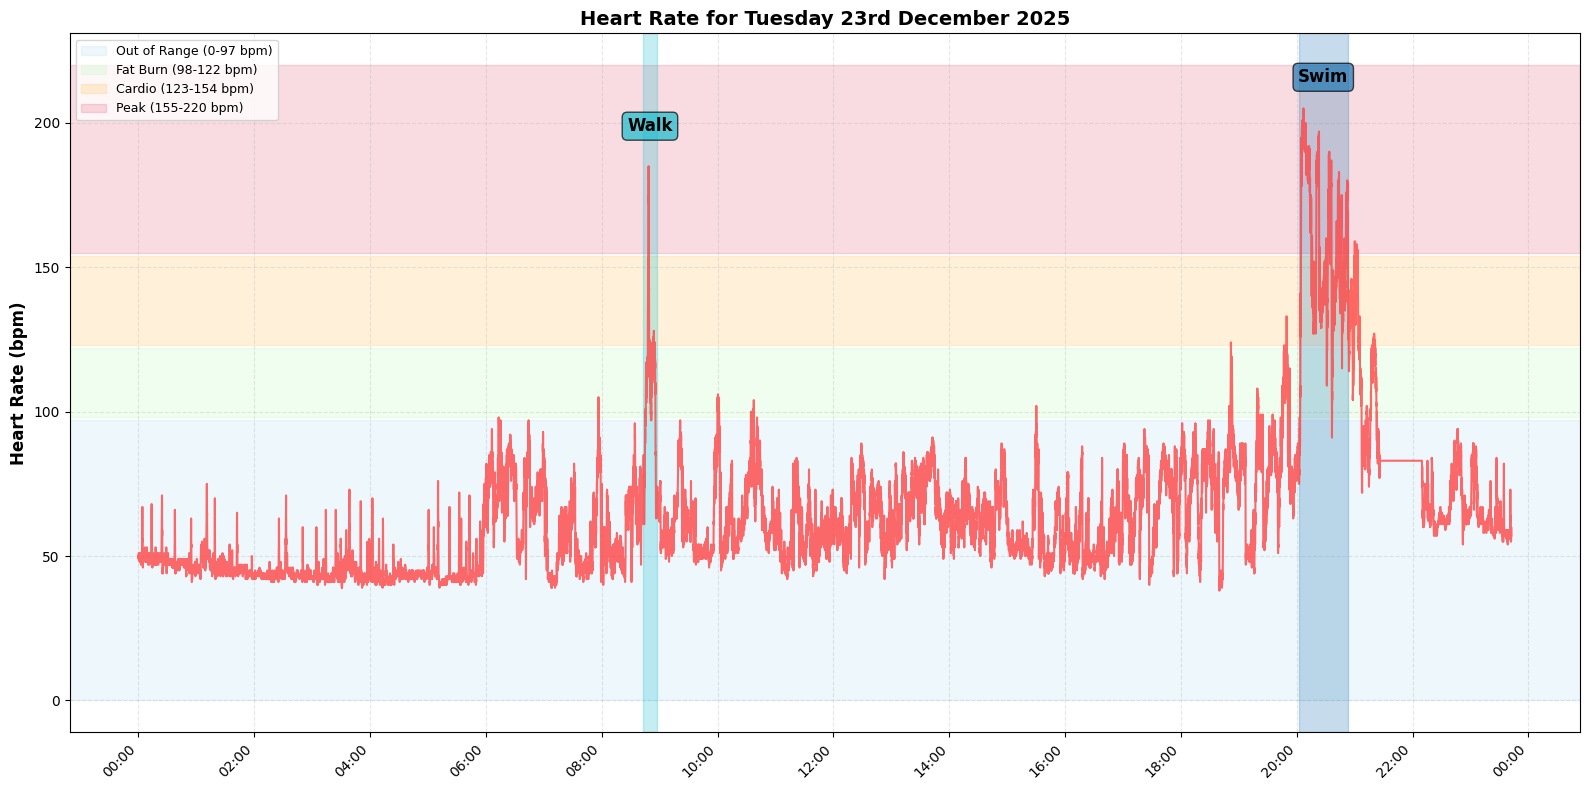

In [31]:
if not df_hr_intra.empty and len(df_activity_records) > 0:
    df_hr_plot = df_hr_intra.copy()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot HR zones as background bands
    for zone_name, zone_info in hr_zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                  alpha=0.15, color=zone_info['color'], 
                  label=f"{zone_name} ({zone_info['range'][0]}-{zone_info['range'][1]} bpm)")
    
    # Plot heart rate line
    ax.plot(df_hr_plot['time'], df_hr_plot['value'], 
           color='#ff4444', linewidth=1.5, alpha=0.8, zorder=5)
    
    # Highlight activity periods
    activity_colors = plt.cm.tab10(np.linspace(0, 1, len(df_activity_records)))

    # Stagger labels at different heights
    label_heights = [0.95, 0.88, 0.81, 0.74]  # Cycle through these

    for idx, (activity_idx, activity) in enumerate(df_activity_records.iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity)
        
        # Add vertical span for activity
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color=activity_colors[idx], 
                  zorder=2)
        
        # Add text label at the top
        mid_time = activity_start + (activity_end - activity_start) / 2
        height_pct = label_heights[idx % len(label_heights)]
            
        # Use transform to place in axes coordinates for y, data coordinates for x
        ax.text(mid_time, height_pct, 
               activity['ActivityName'], 
               ha='center', va='top', fontsize=12, fontweight='bold',
               transform=ax.get_xaxis_transform(),  # x=data coords, y=axes coords (0-1)
               bbox=dict(boxstyle='round,pad=0.3', facecolor=activity_colors[idx], alpha=0.7))
    
    # Customize plot
    # ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title(f'Heart Rate for {formatted_date}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Need both heart rate data and activity records for timeline view")

---

## Hourly Steps Analysis 👣

24-hour visualization showing total steps for each hour of the day.

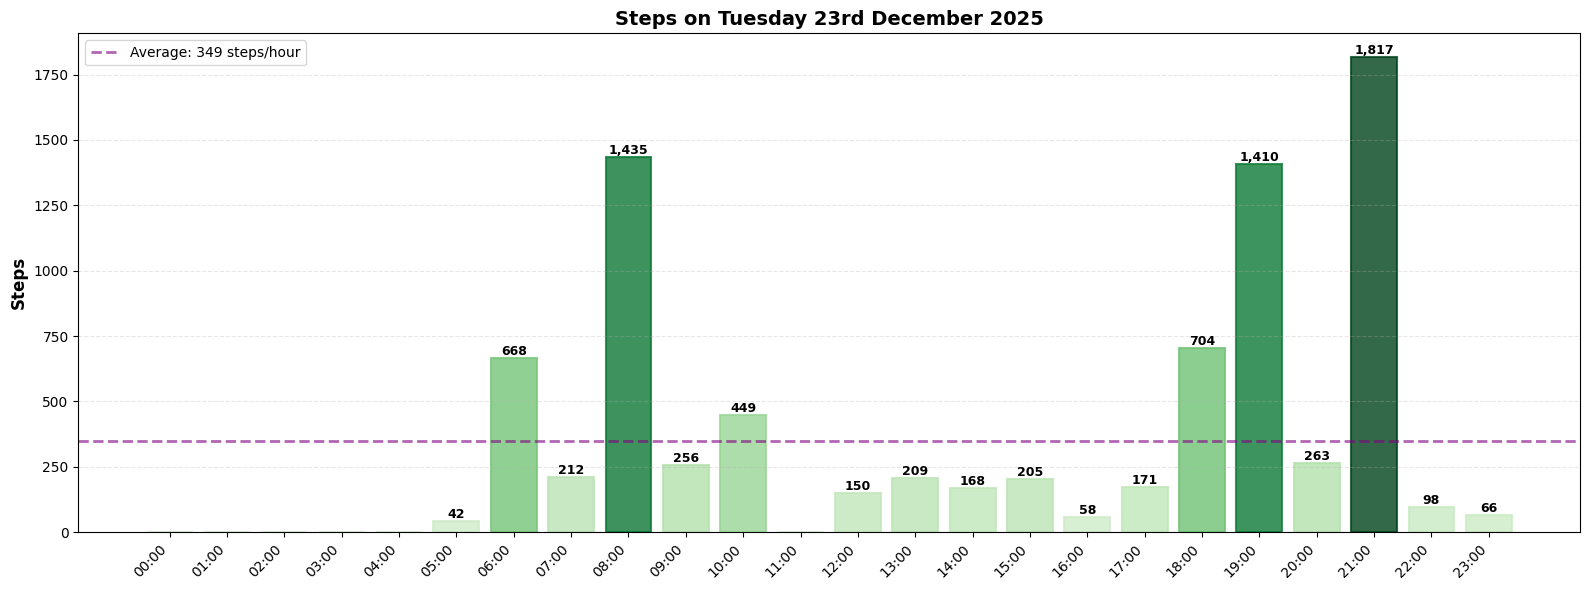

In [32]:
if not df_steps_intra.empty:
    df_steps_plot = df_steps_intra.copy()
    # Extract hour from timestamp
    df_steps_plot['hour'] = df_steps_plot['time'].dt.hour
    
    # Group by hour and sum steps
    hourly_steps = df_steps_plot.groupby('hour')['value'].sum().reset_index()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure we have all 24 hours (fill missing hours with 0)
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Create bar chart
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color='#4CAF50', edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Color bars based on step count (gradient effect)
    max_steps = hourly_steps['steps'].max()
    if max_steps > 0:
        colors = plt.cm.Greens(hourly_steps['steps'] / max_steps * 0.8 + 0.2)
        for bar, color in zip(bars, colors):
            bar.set_color(color)
    
    # Add value labels on top of bars
    for idx, row in hourly_steps.iterrows():
        if row['steps'] > 0:
            ax.text(row['hour'], row['steps'], 
                   f"{int(row['steps']):,}", 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Customize plot
    # ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Steps', fontsize=12, fontweight='bold')
    ax.set_title(f'Steps on {formatted_date}', fontsize=14, fontweight='bold')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add horizontal line for average steps per hour
    avg_steps_per_hour = hourly_steps['steps'].mean()
    ax.axhline(avg_steps_per_hour, color='purple', linestyle='--', linewidth=2, 
              alpha=0.6, label=f'Average: {avg_steps_per_hour:.0f} steps/hour')
    
    ax.legend(loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  No steps data available")
    print("Make sure you've run the earlier cells that load step data into 'df_steps_intra'")

---

## Workout Analysis 🏃‍♂️

In [33]:
# Analyse ALL activities
MILES_TO_KM = 1.609344

if len(df_activity_records) > 0:
    print(f"Found {len(df_activity_records)} activity session(s)\n")
    total_calories = df_activity_records['calories'].sum()
    print(f"🔥 Total calories burned: {total_calories:.0f} kcal\n")
    
    for idx, activity in df_activity_records.sort_values('time').iterrows():
        print(f"{'='*60}")
        print(f"{activity['ActivityName']} - {activity['time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"{'='*60}\n")
        
        duration_sec = activity['duration'] / 1000
        duration_min = duration_sec / 60
        
        print(f"⏱️  Duration: {int(duration_min)}:{int((duration_min % 1) * 60):02d}")
        print(f"🔥 Calories: {activity['calories']:.0f} kcal")
        
        if pd.notna(activity.get('steps')) and activity['steps'] > 0:
            print(f"👣 Steps: {activity['steps']:.0f}")
        
        if pd.notna(activity.get('averageHeartRate')):
            print(f"❤️  Avg HR: {activity['averageHeartRate']:.0f} bpm")
        
        # Distance-based metrics (skip if no distance)
        has_distance = pd.notna(activity.get('distance')) and activity['distance'] > 0
        
        if has_distance:
            distance_miles = activity['distance']
            distance_km = distance_miles * MILES_TO_KM
            
            print(f"📏 Distance: {distance_km:.2f} km ({distance_miles:.2f} mi)")
            
            # Pace and speed
            pace_sec_per_km = duration_sec / distance_km
            speed_kmh = distance_km / (duration_sec / 3600)
            
            print(f"⚡ Pace: {int(pace_sec_per_km // 60)}:{int(pace_sec_per_km % 60):02d} /km")
            print(f"⚡ Speed: {speed_kmh:.2f} km/h")
            
            if pd.notna(activity.get('steps')) and activity['steps'] > 0:
                print(f"⚡ Steps per minute: {activity['steps'] / duration_min:.0f} spm")
            
            if pd.notna(activity.get('elevationGain')):
                print(f"⛰️  Elevation: +{activity['elevationGain']:.0f} m")
            
            # Efficiency
            print(f"\n📊 Efficiency:")
            print(f"   {activity['calories'] / distance_km:.1f} kcal/km")
            if pd.notna(activity.get('steps')) and activity['steps'] > 0:
                print(f"   {activity['steps'] / distance_km:.0f} steps/km")
                print(f"   {distance_km * 1000 / activity['steps']:.2f} m/step")
            
            # Km splits
            if distance_km >= 1.0:
                print(f"\n📊 Estimated Splits:")
                for km in range(1, int(distance_km) + 1):
                    elapsed = pace_sec_per_km * km
                    print(f"   km {km}: {int(pace_sec_per_km // 60)}:{int(pace_sec_per_km % 60):02d} | elapsed {int(elapsed // 60)}:{int(elapsed % 60):02d}")
                
                # Final partial km
                remaining = distance_km - int(distance_km)
                if remaining >= 0.1:
                    partial_time = remaining * pace_sec_per_km
                    print(f"   {remaining:.2f} km: {int(partial_time // 60)}:{int(partial_time % 60):02d} | elapsed {int(duration_sec // 60)}:{int(duration_sec % 60):02d}")
        
        # Heart rate analysis
        if not df_hr_intra.empty:
            try:
                start, end, _ = extract_activity_time_window(activity, 'Europe/London')
                
                hr_data = df_hr_intra[(df_hr_intra['time'] >= start) & (df_hr_intra['time'] <= end)]
                
                if not hr_data.empty:
                    vals = hr_data['value']
                    print(f"\n❤️  HR Analysis ({len(hr_data):,} samples):")
                    print(f"   Avg: {vals.mean():.0f} | Min: {vals.min():.0f} | Max: {vals.max():.0f} bpm")
                    
                    for zone_name, zone_info in hr_zones.items():
                        lo, hi = zone_info['range']
                        in_zone = hr_data[(vals >= lo) & (vals < hi)]
                        pct = len(in_zone) / len(hr_data) * 100
                        if pct > 0:
                            print(f"   {zone_name}: {pct:.1f}% ({len(in_zone) / 60:.1f} min)")
            except Exception as e:
                print(f"\n⚠️  HR analysis failed: {e}")
        
        print()

else:
    print("No activities found for this date")

Found 2 activity session(s)

🔥 Total calories burned: 561 kcal

Walk - 2025-12-23 08:43

⏱️  Duration: 13:48
🔥 Calories: 101 kcal
👣 Steps: 1229
❤️  Avg HR: 109 bpm
📏 Distance: 0.94 km (0.58 mi)
⚡ Pace: 14:45 /km
⚡ Speed: 4.07 km/h
⚡ Steps per minute: 89 spm
⛰️  Elevation: +0 m

📊 Efficiency:
   108.0 kcal/km
   1314 steps/km
   0.76 m/step

❤️  HR Analysis (423 samples):
   Avg: 109 | Min: 61 | Max: 185 bpm
   Out of Range: 23.9% (1.7 min)
   Fat Burn: 58.2% (4.1 min)
   Cardio: 10.4% (0.7 min)
   Peak: 4.7% (0.3 min)

Swim - 2025-12-23 20:01

⏱️  Duration: 51:09
🔥 Calories: 460 kcal
❤️  Avg HR: 155 bpm
📏 Distance: 2.40 km (1.49 mi)
⚡ Pace: 21:19 /km
⚡ Speed: 2.81 km/h
⛰️  Elevation: +0 m

📊 Efficiency:
   191.7 kcal/km

📊 Estimated Splits:
   km 1: 21:19 | elapsed 21:19
   km 2: 21:19 | elapsed 42:38
   0.40 km: 8:31 | elapsed 51:10

❤️  HR Analysis (1,577 samples):
   Avg: 156 | Min: 75 | Max: 205 bpm
   Out of Range: 3.2% (0.8 min)
   Fat Burn: 3.9% (1.0 min)
   Cardio: 45.6% (12.0 

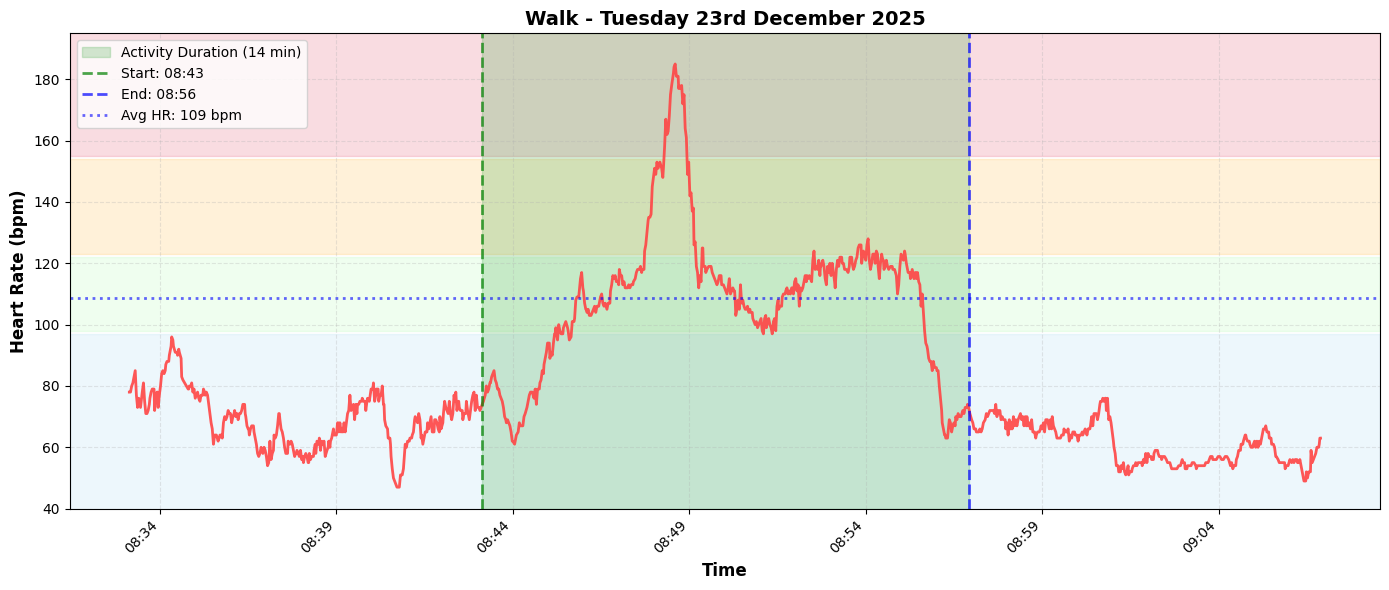


Walk HR Stats:
  Duration: 14 minutes
  Avg HR: 109 bpm
  Min HR: 61 bpm
  Max HR: 185 bpm
  HR Range: 124 bpm

  Time in HR Zones:
    Out of Range: 1.7 min (23.9%)
    Fat Burn: 4.1 min (58.2%)
    Cardio: 0.7 min (10.4%)
    Peak: 0.3 min (4.7%)

--------------------------------------------------------------------------------



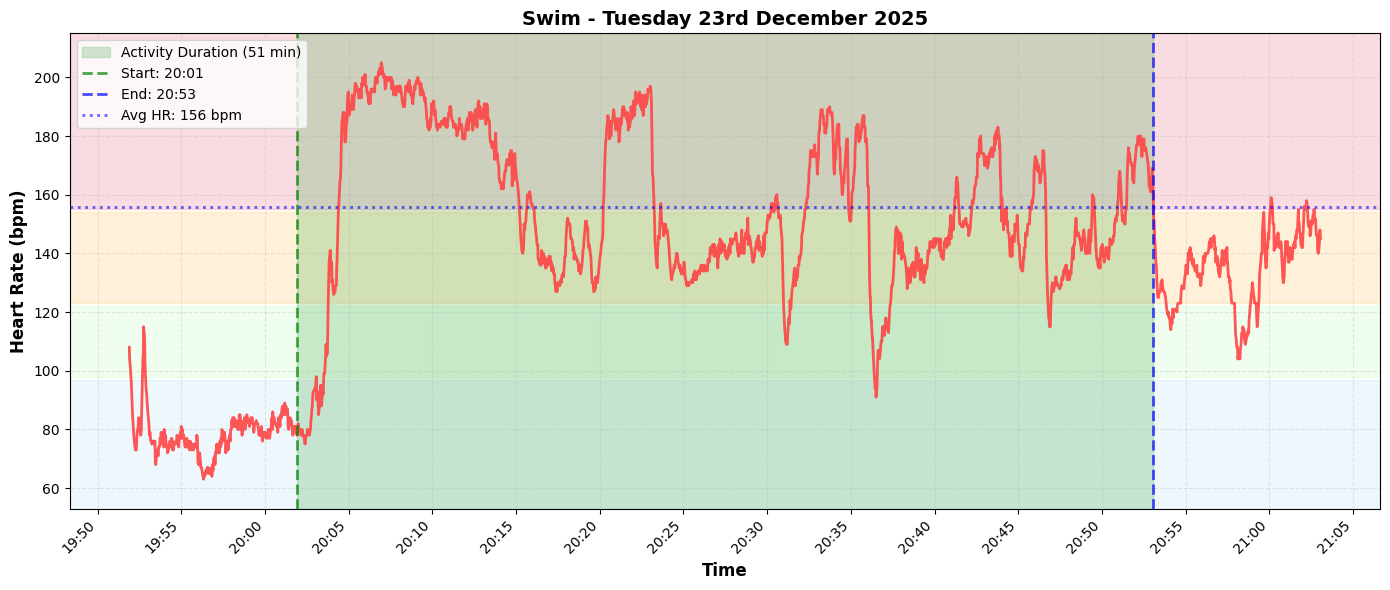


Swim HR Stats:
  Duration: 51 minutes
  Avg HR: 156 bpm
  Min HR: 75 bpm
  Max HR: 205 bpm
  HR Range: 130 bpm

  Time in HR Zones:
    Out of Range: 0.8 min (3.2%)
    Fat Burn: 1.0 min (3.9%)
    Cardio: 12.0 min (45.6%)
    Peak: 12.2 min (46.5%)

--------------------------------------------------------------------------------



In [34]:
if not df_hr_intra.empty and len(df_activity_records) > 0:   
    # Create a plot for each activity
    for idx, (activity_idx, activity) in enumerate(df_activity_records.sort_values('time').iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Add 10-minute buffer before and after activity
        buffer = timedelta(minutes=10)
        plot_start = activity_start - buffer
        plot_end = activity_end + buffer
        
        # Filter HR data for this time window
        hr_window = df_hr_plot[(df_hr_plot['time'] >= plot_start) & (df_hr_plot['time'] <= plot_end)]
        
        if hr_window.empty:
            print(f"⚠️ No HR data found for {activity['ActivityName']}")
            continue
        
        # Create figure for this activity
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Plot HR zones as background bands
        for zone_name, zone_info in hr_zones.items():
            ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                      alpha=0.15, color=zone_info['color'])
        
        # Plot heart rate line
        ax.plot(hr_window['time'], hr_window['value'], 
               color='#ff4444', linewidth=2, alpha=0.9)
        
        # Highlight the actual activity period (without buffer)
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color='#4CAF50', 
                  label=f"Activity Duration ({duration:.0f} min)", zorder=1)
        
        # Add vertical lines for activity start/end
        ax.axvline(activity_start, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Start: {activity_start.strftime("%H:%M")}')
        ax.axvline(activity_end, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'End: {activity_end.strftime("%H:%M")}')
        
        # Calculate stats for this activity window
        activity_hr = hr_window[(hr_window['time'] >= activity_start) & (hr_window['time'] <= activity_end)]
        if not activity_hr.empty:
            avg_hr = activity_hr['value'].mean()
            min_hr = activity_hr['value'].min()
            max_hr = activity_hr['value'].max()
            
            # Add horizontal line for average HR
            ax.axhline(avg_hr, color='blue', linestyle=':', linewidth=2, alpha=0.6, 
                      label=f'Avg HR: {avg_hr:.0f} bpm')
        
        # Customize plot
        activity_name = activity['ActivityName']
        start_time_str = activity_start.strftime('%H:%M')
        ax.set_xlabel('Time', fontsize=12, fontweight='bold')
        ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
        ax.set_title(f'{activity_name} - {formatted_date}', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Format x-axis
        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Set y-axis limits with some padding
        if not hr_window.empty:
            y_min = max(40, hr_window['value'].min() - 10)
            y_max = min(220, hr_window['value'].max() + 10)
            ax.set_ylim(y_min, y_max)
        
        # Legend
        ax.legend(loc='upper left', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print stats
        if not activity_hr.empty:
            print(f"\n{activity_name} HR Stats:")
            print(f"  Duration: {duration:.0f} minutes")
            print(f"  Avg HR: {avg_hr:.0f} bpm")
            print(f"  Min HR: {min_hr:.0f} bpm")
            print(f"  Max HR: {max_hr:.0f} bpm")
            print(f"  HR Range: {max_hr - min_hr:.0f} bpm")
            
            # Calculate time in each zone during this activity
            print(f"\n  Time in HR Zones:")
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = activity_hr[
                    (activity_hr['value'] >= zone_info['range'][0]) &
                    (activity_hr['value'] < zone_info['range'][1])
                ]
                if len(hr_in_zone) > 0:
                    minutes_in_zone = len(hr_in_zone) / 60
                    percentage = (len(hr_in_zone) / len(activity_hr)) * 100
                    print(f"    {zone_name}: {minutes_in_zone:.1f} min ({percentage:.1f}%)")
            
        print("\n" + "-"*80 + "\n")
    
else:
    print("Need both heart rate data and activity records for individual activity timelines")

---

## Walk GPS Visualization 🗺️

Map visualization showing the route taken during walk activities.

In [35]:
# Load GPS data
df_gps = dfs.get('GPS')

# Find walk activities
if not df_activity_records.empty and 'ActivityName' in df_activity_records.columns:
    walk_activities = df_activity_records[df_activity_records['ActivityName'] == 'Walk'].copy()
else:
    walk_activities = pd.DataFrame()

if len(walk_activities) > 0 and df_gps is not None and not df_gps.empty:
    print(f"Found {len(walk_activities)} walk activity(ies) with {len(df_gps)} GPS points\n")
    
    for idx, walk in walk_activities.iterrows():
        # Get activity time window
        activity_start, activity_end, duration = extract_activity_time_window(walk, 'Europe/London')
        
        # Filter GPS data for this walk
        walk_gps = df_gps[(df_gps['time'] >= activity_start) & (df_gps['time'] <= activity_end)]
        
        if not walk_gps.empty:
            print(f"\n{'='*80}")
            print(f"GPS DATA FOR WALK - {activity_start.strftime('%Y-%m-%d %H:%M')}")
            print(f"{'='*80}\n")
            print(f"GPS points during walk: {len(walk_gps)}")
            print(f"Time range: {walk_gps['time'].min()} to {walk_gps['time'].max()}")
            
            # Look for exact column names first
            lat_col = 'lat' if 'lat' in walk_gps.columns else None
            lon_col = 'lon' if 'lon' in walk_gps.columns else None
            
            # If not found, try alternative names
            if lat_col is None:
                for col in walk_gps.columns:
                    if col.lower() == 'latitude':
                        lat_col = col
                        break
            
            if lon_col is None:
                for col in walk_gps.columns:
                    if col.lower() in ['longitude', 'lng']:
                        lon_col = col
                        break
            
            if lat_col and lon_col:
                print(f"Latitude column: {lat_col}")
                print(f"Longitude column: {lon_col}")
                print(f"\nCoordinate range:")
                print(f"  Lat: {walk_gps[lat_col].min():.6f} to {walk_gps[lat_col].max():.6f}")
                print(f"  Lon: {walk_gps[lon_col].min():.6f} to {walk_gps[lon_col].max():.6f}")
                
                # Create a simple scatter plot of the route
                fig, ax = plt.subplots(figsize=(12, 10))
                
                # Plot the route as a line with gradient coloring by time
                points = ax.scatter(walk_gps[lon_col], walk_gps[lat_col], 
                                  c=range(len(walk_gps)), cmap='viridis', 
                                  s=10, alpha=0.6, zorder=2)
                
                # Connect the points with a line
                ax.plot(walk_gps[lon_col], walk_gps[lat_col], 
                       color='blue', linewidth=1, alpha=0.3, zorder=1)
                
                # Mark start and end points
                ax.scatter(walk_gps[lon_col].iloc[0], walk_gps[lat_col].iloc[0], 
                          color='green', s=200, marker='o', edgecolor='black', 
                          linewidth=2, label='Start', zorder=3)
                ax.scatter(walk_gps[lon_col].iloc[-1], walk_gps[lat_col].iloc[-1], 
                          color='red', s=200, marker='s', edgecolor='black', 
                          linewidth=2, label='End', zorder=3)
                
                # Add colorbar
                cbar = plt.colorbar(points, ax=ax, label='Time progression')
                
                ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
                ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
                ax.set_title(f'Walk Route - {formatted_date}', fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3, linestyle='--')
                ax.legend(loc='upper right', fontsize=10)
                ax.set_aspect('equal', adjustable='box')
                
                plt.tight_layout()
                plt.show()
            else:
                print(f"⚠️  Could not find latitude/longitude columns in GPS data")
                print(f"Available columns: {walk_gps.columns.tolist()}")
        else:
            print(f"⚠️  No GPS data found for walk at {activity_start.strftime('%H:%M')}")
            
elif len(walk_activities) == 0:
    print("No walk activities found for this date")
elif df_gps is None or df_gps.empty:
    print("No GPS data available for this date")
else:
    print("GPS data not loaded")

No GPS data available for this date


## Swim-Specific Analysis 🏊

In [36]:
# Configuration
POOL_LENGTH = 25  # meters
MILES_TO_KM = 1.609344  # Conversion factor

# Find all swim activities - check if df is empty first
if not df_activity_records.empty and 'ActivityName' in df_activity_records.columns:
    swim_activities = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].copy()
else:
    swim_activities = pd.DataFrame()

if len(swim_activities) > 0:
    # print(f"Found {len(swim_activities)} swim session(s)\n")
    
    for idx, swim in swim_activities.iterrows():
        print(f"{'='*80}")
        print(f"SWIM SESSION ANALYSIS - {formatted_date}")
        print(f"{'='*80}\n")
        
        # FIX: Fitbit API returns swim distances in MILES, not kilometers!
        # Convert to meters correctly
        distance_from_api = swim['distance']  # This is in MILES for swimming
        distance_m = distance_from_api * MILES_TO_KM * 1000  # Convert miles -> km -> meters
        distance_km = distance_m / 1000
        
        # print(f"⚠️ Note: Fitbit returns swim distance in miles ({distance_from_api:.3f} mi)")
        print(f"📏 Distance: {distance_m:.0f} meters ({distance_km:.2f} km)")
        
        # Duration
        duration_min = swim['duration'] / 1000 / 60
        duration_sec = swim['duration'] / 1000
        
        print(f"⏱️ Duration: {duration_min:.1f} minutes ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {swim['calories']:.0f} kcal\n")
        
        # Calculate pace per 100m with CORRECT distance
        pace_sec_per_100m = duration_sec / (distance_m / 100)
        pace_min = int(pace_sec_per_100m // 60)
        pace_sec = int(pace_sec_per_100m % 60)
        
        print(f"🏊 Pace per 100m: {pace_min}:{pace_sec:02d} min/100m")
        
        # Laps in 25m pool
        laps = distance_m / POOL_LENGTH
        print(f"🔄 Laps: {laps:.1f}")
        
        # # Length breakdown
        # # complete_lengths = int(distance_m / POOL_LENGTH)
        # remaining_meters = distance_m % POOL_LENGTH
        # print(f"   = {complete_lengths} lengths", end='')
        # if remaining_meters >= 1:
        #     print(f" + {remaining_meters:.0f}m")
        # else:
        #     print()
        
        # Average time per lap
        sec_per_lap = duration_sec / laps
        lap_min = int(sec_per_lap // 60)
        lap_sec = int(sec_per_lap % 60)
        print(f"⏱️ Average time per lap: {lap_min}:{lap_sec:02d}")

        # Recalculate speed with correct distance
        speed_kmh = (distance_km / duration_sec) * 3600
        print(f"⚡ Speed: {speed_kmh:.2f} km/h")
        
        print(f"\n📊 Additional Metrics:")
        print(f"   Calories per 100m: {(swim['calories'] / (distance_m / 100)):.1f} kcal")
        print(f"   Meters per minute: {distance_m / duration_min:.1f} m/min")
        
        print(f"\n")
else:
    print("No swim activities found for this date")

SWIM SESSION ANALYSIS - Tuesday 23rd December 2025

📏 Distance: 2400 meters (2.40 km)
⏱️ Duration: 51.2 minutes (3070 seconds)
🔥 Calories: 460 kcal

🏊 Pace per 100m: 2:07 min/100m
🔄 Laps: 96.0
⏱️ Average time per lap: 0:31
⚡ Speed: 2.81 km/h

📊 Additional Metrics:
   Calories per 100m: 19.2 kcal
   Meters per minute: 46.9 m/min




---

## Activity Level Visualization 📊

Visual summary of time spent at each activity level throughout the day.

ACTIVITY LEVEL DISTRIBUTION



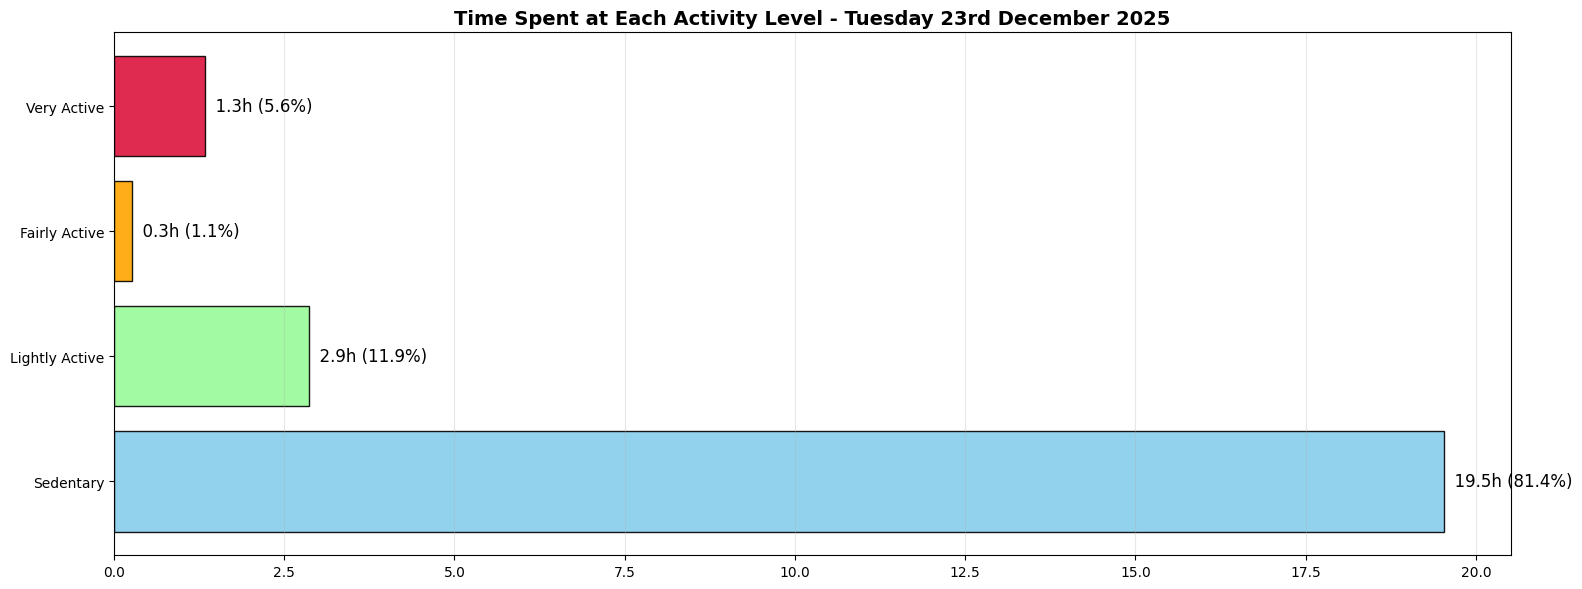

In [37]:
# Activity Level Distribution Visualization
# Uses level_data from earlier cell

if 'level_data' in locals() and level_data:
    print("="*80)
    print("ACTIVITY LEVEL DISTRIBUTION")
    print("="*80 + "\n")
    
    # Create visualizations
    fig, ax = plt.subplots(figsize=(16, 6))
    
    levels = [item['level'] for item in level_data]
    hours = [item['hours'] for item in level_data]
    colors = [item['color'] for item in level_data]
    
    bars = ax.barh(levels, hours, color=colors, edgecolor='black', linewidth=1, alpha=0.9)
    
    # Add value labels
    for bar, item in zip(bars, level_data):
        width = bar.get_width()
        label = f"{item['hours']:.1f}h ({item['percentage']:.1f}%)"
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'  {label}', 
                va='center', fontsize=12, fontweight='normal')
    
    # ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    # ax.set_ylabel('Activity Level', fontsize=12, fontweight='bold')
    ax.set_title(f'Time Spent at Each Activity Level - {formatted_date}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # # Print summary stats
    # print(f"\n📊 Summary:")
    # total_minutes = sum(item['minutes'] for item in level_data)
    # total_hours = total_minutes / 60
    # print(f"  Total tracked time: {total_hours:.1f} hours ({total_minutes:.0f} minutes)")
    
    # # Active vs sedentary
    # active_minutes = sum(item['minutes'] for item in level_data if item['level'] != 'Sedentary')
    # sedentary_minutes = sum(item['minutes'] for item in level_data if item['level'] == 'Sedentary')
    # print(f"  Active time: {active_minutes/60:.1f} hours ({active_minutes:.0f} minutes)")
    # print(f"  Sedentary time: {sedentary_minutes/60:.1f} hours ({sedentary_minutes:.0f} minutes)")
    
    # # Fairly/Very active
    # fairly_very_active = sum(item['minutes'] for item in level_data 
    #                         if item['level'] in ['Fairly Active', 'Very Active'])
    # if fairly_very_active > 0:
    #     print(f"  Fairly/Very Active: {fairly_very_active/60:.1f} hours ({fairly_very_active:.0f} minutes)")
        
    #     # WHO recommendation
    #     daily_target = 150 / 7  # ~21.4 minutes per day
    #     if fairly_very_active >= daily_target:
    #         print(f"  ✅ WHO activity goal achieved! ({(fairly_very_active/daily_target)*100:.0f}% of daily target)")
    #     else:
    #         shortfall = daily_target - fairly_very_active
    #         print(f"  ⚠️  {shortfall:.0f} minutes short of WHO daily target")
    
else:
    print("⚠️  No activity level data available to plot")
    print("Make sure you've run the earlier cells that generate 'level_data'")

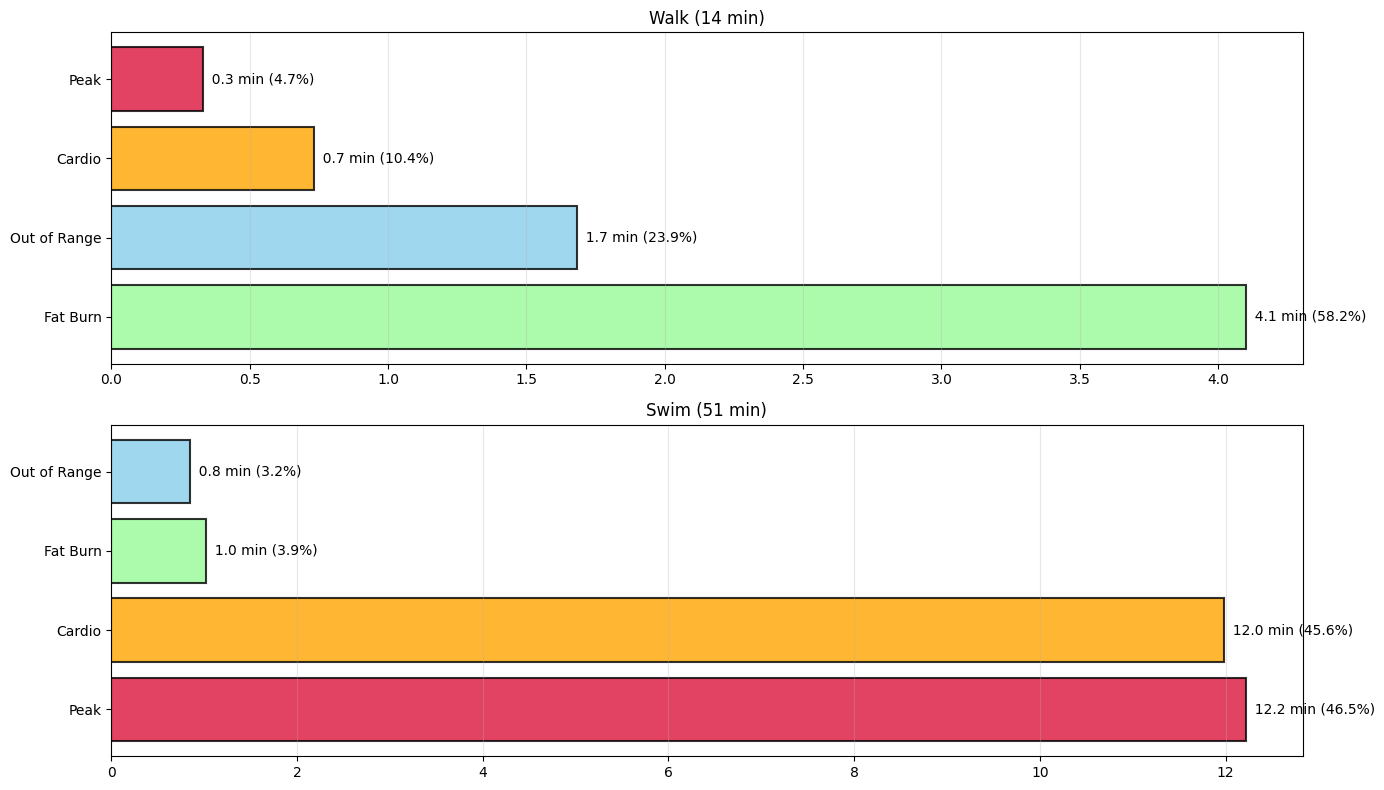


📊 Summary:
--------------------------------------------------------------------------------
Activity             Duration     Primary Zone         Avg HR    
--------------------------------------------------------------------------------
Walk                    14 min    Fat Burn        (29.7%)    109 bpm
Swim                    51 min    Peak            (23.9%)    156 bpm
--------------------------------------------------------------------------------


In [38]:
if not df_hr_intra.empty and not df_activity_records.empty:
    df_hr_plot = df_hr_intra.copy()
    
    num_activities = len(df_activity_records)
    
    # Create subplots - one row per activity
    fig, axes = plt.subplots(num_activities, 1, figsize=(14, 4 * num_activities))

    # Handle case of single activity (axes won't be array)
    if num_activities == 1:
        axes = [axes]
    
    for idx, (activity_idx, activity) in enumerate(df_activity_records.sort_values('time').iterrows()):
        activity_name = activity.get('ActivityName', 'Unknown')
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Filter HR data for this activity
        activity_hr = df_hr_plot[(df_hr_plot['time'] >= activity_start) & (df_hr_plot['time'] <= activity_end)]
        
        if activity_hr.empty:
            axes[idx].text(0.5, 0.5, f'No HR data for {activity_name}', 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
            continue
        
        # Calculate time in each zone
        zone_stats = []
        for zone_name, zone_info in hr_zones.items():
            hr_in_zone = activity_hr[
                (activity_hr['value'] >= zone_info['range'][0]) &
                (activity_hr['value'] < zone_info['range'][1])
            ]
            minutes_in_zone = len(hr_in_zone) / 60
            percentage = (len(hr_in_zone) / len(activity_hr)) * 100
            
            if minutes_in_zone > 0:
                zone_stats.append({
                    'zone': zone_name,
                    'minutes': minutes_in_zone,
                    'percentage': percentage,
                    'color': zone_info['color'],
                    'range': zone_info['range']
                })
        
        if not zone_stats:
            continue
        
        # Sort by percentage descending
        zone_stats.sort(key=lambda x: x['percentage'], reverse=True)
        
        # BAR CHART
        ax = axes[idx]
        
        zones = [z['zone'] for z in zone_stats]
        minutes = [z['minutes'] for z in zone_stats]
        colors = [z['color'] for z in zone_stats]
        
        bars = ax.barh(zones, minutes, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
        
        # Add value labels
        for bar, stat in zip(bars, zone_stats):
            width = bar.get_width()
            label = f"{stat['minutes']:.1f} min ({stat['percentage']:.1f}%)"
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'  {label}', 
                   va='center', fontsize=10, fontweight='normal')
        
        # Format bar chart
        start_time = activity_start.strftime('%H:%M')
        # ax.set_xlabel('Time (minutes)', fontsize=11, fontweight='bold')
        ax.set_title(f'{activity_name} ({duration:.0f} min)', 
                    fontsize=12, fontweight='normal')
        ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # ========== SUMMARY TABLE ==========
    print("\n📊 Summary:")
    print("-" * 80)
    print(f"{'Activity':<20} {'Duration':<12} {'Primary Zone':<20} {'Avg HR':<10}")
    print("-" * 80)
    
    for activity_idx, activity in df_activity_records.sort_values('time').iterrows():
        activity_name = activity.get('ActivityName', 'Unknown')
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        activity_hr = df_hr_plot[(df_hr_plot['time'] >= activity_start) & (df_hr_plot['time'] <= activity_end)]
        
        if not activity_hr.empty:
            # Find primary zone
            zone_times = {}
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = activity_hr[
                    (activity_hr['value'] >= zone_info['range'][0]) &
                    (activity_hr['value'] < zone_info['range'][1])
                ]
                zone_times[zone_name] = len(hr_in_zone) / 60
            
            primary_zone = max(zone_times, key=zone_times.get)
            primary_zone_pct = (zone_times[primary_zone] / duration) * 100
            
            avg_hr = activity_hr['value'].mean()
            
            print(f"{activity_name:<20} {duration:>5.0f} min    {primary_zone:<15} ({primary_zone_pct:>4.1f}%)  {avg_hr:>5.0f} bpm")
    
    print("-" * 80)
    
elif df_activity_records.empty:
    print("⚠️  No logged activities found for this date")
else:
    print("⚠️  No heart rate data available")